In [6]:
import os
import time
import torch
import numpy as np
import pandas as pd
from pathlib import Path
import scipy.stats as stats
from datetime import datetime
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from coinbase.rest import RESTClient
from plotly.subplots import make_subplots

In [7]:
print(f"CUDA {'is' if torch.cuda.is_available() else 'is not'} available for GPU Machine Learning")

CUDA is available for GPU Machine Learning


In [19]:
def retrieve_ticker_minute_data(ticker: str, start_date: str, end_date: str):
    client = RESTClient(key_file="./coinbase_cloud_api_key.json")
    time_delta = 18000
    start = int(pd.Timestamp(start_date).timestamp())
    end_time = int(pd.Timestamp(end_date).timestamp())
    df_list = []
    while start < end_time:
        end = min(start + time_delta, end_time)
        start_str = str(start)
        end_str = str(end)
        df_chunk = pd.DataFrame(client.get_candles(product_id=ticker, start=start_str, end=end_str, granularity='ONE_MINUTE'))
        df_list.append(df_chunk)
        start = end

    df = pd.concat(df_list, axis=0)
    return df


def preprocess_data(df: pd.DataFrame):
    df['Time_Stamp'] = df['candles'].apply(lambda x: datetime.fromtimestamp(int(x['start'])))
    df['Low'] = df['candles'].apply(lambda x: np.float64(x['low']))
    df['High'] = df['candles'].apply(lambda x: np.float64(x['high']))
    df['Open'] = df['candles'].apply(lambda x: np.float64(x['open']))
    df['Close'] = df['candles'].apply(lambda x: np.float64(x['close']))
    df['Volume'] = df['candles'].apply(lambda x: np.float64(x['volume']))
    df['Time_Stamp'] = pd.to_datetime(df['Time_Stamp'])
    df['Date'] = df['Time_Stamp'].apply(lambda time_stamp: time_stamp.strftime('%Y-%m-%d'))
    df['Time'] = df['Time_Stamp'].apply(lambda time_stamp: time_stamp.strftime('%H:%M:%S'))
    df['Time'] = pd.to_datetime(df['Time'])
    df['Date'] = pd.to_datetime(df['Date'])
    df['Date'] = df['Date'].apply(lambda time_stamp: time_stamp.strftime('%Y-%m-%d'))
    df['Time'] = df['Time'].apply(lambda time_stamp: time_stamp.strftime('%H:%M:%S'))
    df.reset_index(inplace=True, drop=True)
    df = df[['Time_Stamp', 'Date', 'Time', 'Open', 'High', 'Close', 'Low', 'Volume']].set_index('Time_Stamp').sort_index()
    return df


def remove_duplicates(data: pd.DataFrame):
    if 'Time_Stamp' == [*data.index.names][0]:
        data.reset_index(inplace=True)

    data = data.drop_duplicates(subset=['Time_Stamp'], keep='last')
    data.reset_index(inplace=True, drop=True)

    if 'Time_Stamp' != [*data.index.names][0]:
        data.set_index('Time_Stamp', inplace=True)

    if 'index' in [*data.columns]:
        data.drop('index', axis=1, inplace=True)

    return data


def fill_in_missing_rows(df: pd.DataFrame):
    df.reset_index(inplace=True)
    required_columns = ["Time_Stamp", "Date", "Time", "Open", "High", "Low", "Close", "Volume"]
    if not all(column in df.columns for column in required_columns):
        raise ValueError(f"DataFrame must contain the following columns: {required_columns}")

    # Convert 'Time_Stamp' to datetime if it is not already
    if not pd.api.types.is_datetime64_any_dtype(df['Time_Stamp']):
        df['Time_Stamp'] = pd.to_datetime(df['Time_Stamp'])

    df.set_index('Time_Stamp', inplace=True)
    complete_time_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq='T')
    df = df.reindex(complete_time_index)
    df['Date'] = df.index.date
    df['Time'] = df.index.time
    df['Close'] = df['Close'].ffill()
    df['Open'] = df['Open'].combine_first(df['Close'].shift(1))
    df['High'] = df['High'].combine_first(df['Close'].shift(1))
    df['Low'] = df['Low'].combine_first(df['Close'].shift(1))
    df['Volume'] = df['Volume'].fillna(0)
    df = df.reset_index().rename(columns={'index': 'Time_Stamp'})
    missing_minutes = pd.date_range(start=df['Time_Stamp'].min(), end=df['Time_Stamp'].max(), freq='T').difference(df['Time_Stamp']).size

    if missing_minutes == 0:
        print("No missing minutes in the dataset.")
    else:
        print(f"There are {missing_minutes} missing minutes in the dataset.")

    return df


def retrieve_preprocessed_ticker_minute_data(ticker: str, start_date: str, end_date: str):
    df = retrieve_ticker_minute_data(ticker=ticker, start_date=start_date, end_date=end_date)
    df = preprocess_data(df)
    df = remove_duplicates(df)
    df = fill_in_missing_rows(df)    
    return df

def create_time_frame(df: pd.DataFrame, time_frame: int):
    df[f'{time_frame}_Minute_cumsum'] = np.ones(df.shape[0], np.int64)
    df[f'{time_frame}_Minute_cumsum'] = df[f'{time_frame}_Minute_cumsum'].cumsum().values
    df[f'{time_frame}_Minute_Complete_Candle'] = np.zeros(df.shape[0], np.int64)
    df[f'{time_frame}_Minute_Complete_Candle'].where(~(df[f'{time_frame}_Minute_cumsum'].values % time_frame == 0), np.int64(1), inplace=True)
    df[f'{time_frame}_Minute_Candle_Counter'] = df[f'{time_frame}_Minute_Complete_Candle'].cumsum().shift().values
    df.loc[0, f'{time_frame}_Minute_Candle_Counter'] = np.int64(0)
    df[f'{time_frame}_Minute_Start_Time'] = df[[f'{time_frame}_Minute_Candle_Counter', 'Start_Time']].groupby(f'{time_frame}_Minute_Candle_Counter')['Start_Time'].transform('first')
    df[f'{time_frame}_Minute_Open'] = df[[f'{time_frame}_Minute_Candle_Counter', 'Open']].groupby(f'{time_frame}_Minute_Candle_Counter')['Open'].transform('first')
    df[f'{time_frame}_Minute_High'] = df.groupby(f'{time_frame}_Minute_Candle_Counter')['High'].cummax().values
    df[f'{time_frame}_Minute_Low'] = df.groupby(f'{time_frame}_Minute_Candle_Counter')['Low'].cummin().values
    df[f'{time_frame}_Minute_Close'] = df['Close']
    df[f'{time_frame}_Minute_Volume'] = df.groupby(f'{time_frame}_Minute_Candle_Counter')['Volume'].cumsum().values
    df.drop(f'{time_frame}_Minute_cumsum', axis=1, inplace=True)
    return df

def create_time_frames(df: pd.DataFrame, time_frames: list):
    df['Start_Time'] = df.index
    for time_frame in time_frames:
        if time_frame == 1:
            continue
            
        df = create_time_frame(df=df, time_frame=time_frame)

    df.rename(
        columns={
            'Open': '1_Minute_Open',
            'High': '1_Minute_High',
            'Low': '1_Minute_Low',
            'Close': '1_Minute_Close', 
            'Volume': '1_Minute_Volume'
        }, inplace=True
    )

    df.drop('Start_Time', axis=1, inplace=True)
    return df.bfill()


def get_critical_value(confidence_interval):
    alpha = 1 - confidence_interval
    critical_value = stats.norm.ppf(1 - alpha / 2)
    return critical_value
    

def create_statistical_features(data: pd.DataFrame, time_frames: list, confidence_intervals: list = [0.95], windows: list = [20], derivatives=1):
    for time_frame in time_frames:
        for window in windows:
    
            if f'{time_frame}_Minute_MA{window}' not in [*data.columns] or f'{time_frame}_Minute_STD{window}' not in [*data.columns]:
                price_sum = data[f'{time_frame}_Minute_Open'] + data[f'{time_frame}_Minute_Low'] + data[f'{time_frame}_Minute_High'] + data[f'{time_frame}_Minute_Close']
                average = price_sum / 4
                data[f'{time_frame}_Minute_MA{window}'] = average.rolling(window=window).mean()
                data[f'{time_frame}_Minute_STD{window}'] = average.rolling(window=window).std()

            for confidence_interval in confidence_intervals:
                if confidence_interval < 0 or confidence_interval > 1:
                    raise ValueError('Confidence Interval must be between 0 and 1')
                    
                critical_value = get_critical_value(confidence_interval=confidence_interval)
                data[f'{time_frame}_Minute_CI{str(int(confidence_interval * 100))}_U_{window}'] = data[f'{time_frame}_Minute_MA{window}'] + critical_value * data[f'{time_frame}_Minute_STD{window}']
                data[f'{time_frame}_Minute_CI{str(int(confidence_interval * 100))}_L_{window}'] = data[f'{time_frame}_Minute_MA{window}'] - critical_value * data[f'{time_frame}_Minute_STD{window}']               

        if derivatives:
            derivative_counter = 0
            for i in range(derivatives):
                derivative_counter += 1
                if derivative_counter == 1:
                    data[f'{time_frame}_Minute_Delta{derivative_counter}'] = ((
                        data[f'{time_frame}_Minute_Open'] + data[f'{time_frame}_Minute_Low'] + data[f'{time_frame}_Minute_High'] + data[f'{time_frame}_Minute_Close']
                    ) / 4).diff(1)
                else:
                    data[f'{time_frame}_Minute_Delta{derivative_counter}'] = data[f'{time_frame}_Minute_Delta{derivative_counter - 1}'].diff(1)

    return data

    
def create_candlestick_chart(df: pd.DataFrame, time_frame: int = 1, confidence_interval: list = 0.95, window: list = 20, derivatives: int = 1):
    data = df.copy()
    
    if 'Time_Stamp' not in data.columns:
        data.reset_index(inplace=True)

    if 'index' in data.columns:
        data.drop('index', axis=1, inplace=True)

    relevant_columns = ['Time_Stamp', 'Date', 'Time']
    relevant_columns.extend([col for col in data.columns if str(time_frame) in col])
    
    if derivatives > 0:
        for derivative in range(1, derivatives + 1):
            relevant_columns.append(f'{time_frame}_Minute_Delta{derivative}')
            
    relevant_columns = [col for col in relevant_columns if col in data.columns]    
    data = data[relevant_columns]
    data = data.loc[data[f'{time_frame}_Minute_Complete_Candle'] == 1, :]
    data.reset_index(inplace=True, drop=True)
    data.sort_values('Time_Stamp', inplace=True)
    data = data.tail(1000)
        
    # Create a subplot figure with 2 rows and shared x-axis
    fig = make_subplots(
        rows=2, cols=1,
        shared_xaxes=True,
        vertical_spacing=0.03,
        row_heights=[0.7, 0.3]
    )

    # Add candlestick trace
    fig.add_trace(go.Candlestick(
        x=data['Time_Stamp'],
        open=data[f'{time_frame}_Minute_Open'],
        high=data[f'{time_frame}_Minute_High'],
        low=data[f'{time_frame}_Minute_Low'],
        close=data[f'{time_frame}_Minute_Close'],
        increasing_line_color='green',
        decreasing_line_color='red',
        name='Candlesticks'
    ), row=1, col=1)

    # Bollinger Bands
    upper_band = f'{time_frame}_Minute_CI{int(confidence_interval * 100)}_U_{window}'
    lower_band = f'{time_frame}_Minute_CI{int(confidence_interval * 100)}_L_{window}'

    if upper_band in data.columns:
        fig.add_trace(go.Scatter(
            x=data['Time_Stamp'],
            y=data[upper_band],
            mode='lines',
            line=dict(color='purple', width=2),
            name=upper_band
        ), row=1, col=1)

    if lower_band in data.columns:
        fig.add_trace(go.Scatter(
            x=data['Time_Stamp'],
            y=data[lower_band],
            mode='lines',
            line=dict(color='purple', width=2),
            name=lower_band
        ), row=1, col=1)

    # Add derivatives
    # if derivatives:
    #     derivative_colors = ['red', 'orange', 'green', 'blue']
    #     for derivative in range(1, derivatives + 1):
    #         derivative_col = f'{time_frame}_Minute_Delta{derivative}'
    #         if derivative_col in data.columns:
    #             fig.add_trace(go.Scatter(
    #                 x=data['Time_Stamp'],
    #                 y=data[derivative_col],
    #                 mode='lines',
    #                 line=dict(color=derivative_colors[derivative], width=2),
    #                 name=derivative_col
    #             ), row=1, col=1)
    
    # Add volume bars in the second row
    fig.add_trace(go.Bar(
        x=data['Time_Stamp'],
        y=data[f'{time_frame}_Minute_Volume'],
        name='Volume',
        marker=dict(
            color=['green' if open_ < close_ else 'red' for open_, close_ in zip(data[f'{time_frame}_Minute_Open'], data[f'{time_frame}_Minute_Close'])],
            line=dict(width=0)  # Remove borders for a cleaner look
        ),
        showlegend=False
    ), row=2, col=1)

    # Update layout for the figure
    fig.update_layout(
        title=f'{time_frame} Minute Candlestick Chart with Volume',
        xaxis=dict(rangeslider=dict(visible=False)),
        xaxis2=dict(title='Time'),
        yaxis=dict(title='Price'),
        yaxis2=dict(title='Volume'),
        hovermode='x unified',
        legend=dict(x=0.01, y=0.99),
        margin=dict(l=40, r=40, t=40, b=40)
    )

    # Customize hover labels for both traces
    fig.update_traces(hoverinfo='x+y+text')

    # Show the figure
    fig.show()

    if 'Time_Stamp' in df.columns:
        df.set_index('Time_Stamp', inplace=True)
        df.sort_index(inplace=True)

    if 'index' in df.columns:
        df.drop('index', axis=1, inplace=True)

In [9]:
time_frames = [1, 3, 5, 10, 15, 30, 60, 120, 180, 240, 300, 360, 420, 480, 1440, 2880, 4320, 5760, 7200, 8640, 10080, 11520, 12960]
ticker='BTC-USDT'
start_date='2023-05-14'
end_date='2024-05-14'

In [10]:
preprocessed_df = retrieve_preprocessed_ticker_minute_data(ticker=ticker, start_date=start_date, end_date=end_date)
preprocessed_df

C:\Users\Amram\AppData\Local\Temp\ipykernel_29628\259110910.py:29: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Time'] = pd.to_datetime(df['Time'])
C:\Users\Amram\AppData\Local\Temp\ipykernel_29628\259110910.py:65: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  complete_time_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq='T')


No missing minutes in the dataset.


C:\Users\Amram\AppData\Local\Temp\ipykernel_29628\259110910.py:75: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  missing_minutes = pd.date_range(start=df['Time_Stamp'].min(), end=df['Time_Stamp'].max(), freq='T').difference(df['Time_Stamp']).size


,Time_Stamp,Date,Time,Open,High,Close,Low,Volume
0,2023-05-13 20:00:00,2023-05-13,20:00:00,26775.63,26775.69,26775.69,26765.48,0.338931
1,2023-05-13 20:01:00,2023-05-13,20:01:00,26785.70,26794.30,26791.01,26785.70,0.226894
2,2023-05-13 20:02:00,2023-05-13,20:02:00,26789.43,26790.42,26784.59,26778.59,0.666486
3,2023-05-13 20:03:00,2023-05-13,20:03:00,26781.55,26781.55,26764.35,26764.35,0.839930
4,2023-05-13 20:04:00,2023-05-13,20:04:00,26764.35,26764.35,26764.35,26764.35,0.000000
...,...,...,...,...,...,...,...,...
527036,2024-05-13 19:56:00,2024-05-13,19:56:00,62904.99,62912.45,62881.90,62881.90,0.053562
527037,2024-05-13 19:57:00,2024-05-13,19:57:00,62891.87,62923.16,62912.49,62891.87,0.068793
527038,2024-05-13 19:58:00,2024-05-13,19:58:00,62921.60,62921.60,62921.16,62913.22,0.017641
527039,2024-05-13 19:59:00,2024-05-13,19:59:00,62921.15,62945.60,62945.60,62921.15,0.050012


In [11]:
df_time_frames = create_time_frames(df=preprocessed_df, time_frames=time_frames)
df_time_frames[[i for i in df_time_frames.columns if 'complete' in i.lower()]].sum()

C:\Users\Amram\AppData\Local\Temp\ipykernel_29628\259110910.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[f'{time_frame}_Minute_Complete_Candle'].where(~(df[f'{time_frame}_Minute_cumsum'].values % time_frame == 0), np.int64(1), inplace=True)
C:\Users\Amram\AppData\Local\Temp\ipykernel_29628\259110910.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because

3_Minute_Complete_Candle        175680
5_Minute_Complete_Candle        105408
10_Minute_Complete_Candle        52704
15_Minute_Complete_Candle        35136
30_Minute_Complete_Candle        17568
60_Minute_Complete_Candle         8784
120_Minute_Complete_Candle        4392
180_Minute_Complete_Candle        2928
240_Minute_Complete_Candle        2196
300_Minute_Complete_Candle        1756
360_Minute_Complete_Candle        1464
420_Minute_Complete_Candle        1254
480_Minute_Complete_Candle        1098
1440_Minute_Complete_Candle        366
2880_Minute_Complete_Candle        183
4320_Minute_Complete_Candle        122
5760_Minute_Complete_Candle         91
7200_Minute_Complete_Candle         73
8640_Minute_Complete_Candle         61
10080_Minute_Complete_Candle        52
11520_Minute_Complete_Candle        45
12960_Minute_Complete_Candle        40
dtype: int64

In [12]:
analyzed_df = create_statistical_features(data=df_time_frames, time_frames=time_frames)
analyzed_df

C:\Users\Amram\AppData\Local\Temp\ipykernel_29628\259110910.py:143: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'{time_frame}_Minute_MA{window}'] = average.rolling(window=window).mean()
C:\Users\Amram\AppData\Local\Temp\ipykernel_29628\259110910.py:144: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'{time_frame}_Minute_STD{window}'] = average.rolling(window=window).std()
C:\Users\Amram\AppData\Local\Temp\ipykernel_29628\259110910.py:151: PerformanceWarning: DataFrame is highly fragmented.  This is usually the resul

,Time_Stamp,Date,Time,1_Minute_Open,1_Minute_High,1_Minute_Close,1_Minute_Low,1_Minute_Volume,3_Minute_Complete_Candle,3_Minute_Candle_Counter,...,11520_Minute_MA20,11520_Minute_STD20,11520_Minute_CI95_U_20,11520_Minute_CI95_L_20,11520_Minute_Delta1,12960_Minute_MA20,12960_Minute_STD20,12960_Minute_CI95_U_20,12960_Minute_CI95_L_20,12960_Minute_Delta1
0,2023-05-13 20:00:00,2023-05-13,20:00:00,26775.63,26775.69,26775.69,26765.48,0.338931,0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-05-13 20:01:00,2023-05-13,20:01:00,26785.70,26794.30,26791.01,26785.70,0.226894,0,0.0,...,NaN,NaN,NaN,NaN,8.4825,NaN,NaN,NaN,NaN,8.4825
2,2023-05-13 20:02:00,2023-05-13,20:02:00,26789.43,26790.42,26784.59,26778.59,0.666486,1,0.0,...,NaN,NaN,NaN,NaN,-1.6050,NaN,NaN,NaN,NaN,-1.6050
3,2023-05-13 20:03:00,2023-05-13,20:03:00,26781.55,26781.55,26764.35,26764.35,0.839930,0,1.0,...,NaN,NaN,NaN,NaN,-5.3425,NaN,NaN,NaN,NaN,-5.3425
4,2023-05-13 20:04:00,2023-05-13,20:04:00,26764.35,26764.35,26764.35,26764.35,0.000000,0,1.0,...,NaN,NaN,NaN,NaN,0.0000,NaN,NaN,NaN,NaN,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
527036,2024-05-13 19:56:00,2024-05-13,19:56:00,62904.99,62912.45,62881.90,62881.90,0.053562,1,175678.0,...,62217.168375,6.965450,62230.820406,62203.516344,-3.5450,62217.168375,6.965454,62230.820414,62203.516336,-3.5450
527037,2024-05-13 19:57:00,2024-05-13,19:57:00,62891.87,62923.16,62912.49,62891.87,0.068793,0,175679.0,...,62217.733375,6.397469,62230.272184,62205.194566,7.6475,62217.733375,6.397473,62230.272192,62205.194558,7.6475
527038,2024-05-13 19:58:00,2024-05-13,19:58:00,62921.60,62921.60,62921.16,62913.22,0.017641,0,175679.0,...,62217.735875,6.397933,62230.275593,62205.196157,2.1675,62217.735875,6.397937,62230.275602,62205.196148,2.1675
527039,2024-05-13 19:59:00,2024-05-13,19:59:00,62921.15,62945.60,62945.60,62921.15,0.050012,1,175679.0,...,62217.746125,6.409986,62230.309467,62205.182783,6.1100,62217.746125,6.409990,62230.309475,62205.182775,6.1100


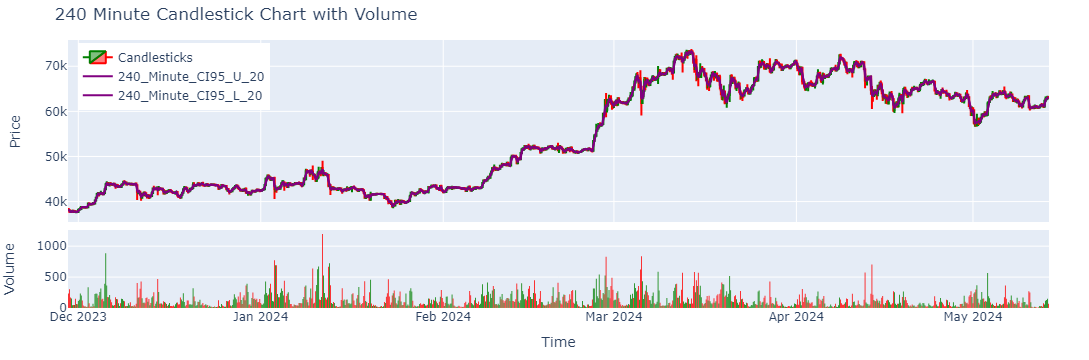

In [21]:
create_candlestick_chart(df=analyzed_df, time_frame=240, confidence_interval=0.95, window=20, derivatives=1)

In [ ]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# Importing the Keras libraries and packages
import keras
from tensorflow.keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import tensorflow as tf

In [ ]:
pip install keras

In [ ]:
training_set = df.iloc[:round(.7*(len(df))),:]
training_set = training_set.iloc[:, 1:2].values

testing_set = df.iloc[round(.7*(len(df))):,:]
testing_set = testing_set.iloc[:, 1:2].values

len(testing_set)

In [ ]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0, 1))
training_set_scaled = sc.fit_transform(training_set)

In [ ]:
# Creating a data structure with 60 timesteps and 1 output
X_train = []
y_train = []
for i in range(600, len(training_set)):
    X_train.append(training_set_scaled[i-600:i, 0])
    y_train.append(training_set_scaled[i, 0])
    
X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape

In [ ]:
# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

In [ ]:
# Initialising the RNN
regressor = Sequential()

In [ ]:
# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

In [ ]:
# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))

In [ ]:
# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))

In [ ]:
# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))

In [ ]:
# Adding the output layer
regressor.add(Dense(units=1))

In [ ]:
# Compiling the RNN
regressor.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="loss",
                                                             patience=3)

In [ ]:
# Fitting the RNN to the Training set    
regressor.fit(X_train, y_train, epochs=100, batch_size=32, callbacks=[full_model_early_stopping])

In [ ]:
import pickle
from joblib import dump, load

In [ ]:
dump(regressor, 'model1.pkl')

In [ ]:
model = load('mlbrain.joblib')

In [ ]:
dataset_test = pd.DataFrame(testing_set)
real_stock_price = dataset_test.iloc[:20, 1:2].values

In [ ]:
dataset_total = pd.concat((df.loc[:round(.7*(len(df))),'open'], dataset_test), axis=0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

In [ ]:
testing_set.shape

In [ ]:
X_test = []
testing_set_scaled = sc.fit_transform(df.iloc[:, 1:2].values)
for i in range(600,len(df)):
    X_test.append(testing_set_scaled[i-69:i, 0])
    
X_test = np.array(X_test)

print(X_test.shape)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

predicted_stock_price = regressor.predict(X_test)
predicted_coin_price = sc.inverse_transform(predicted_stock_price)
predicted_coin_price

In [ ]:
# Visualising the results
plt.plot(testing_set, color='red', label='Real Near Price')
plt.plot(predicted_coin_price, color='blue', label='Predicted Near Stock Price')
plt.title('Near Price Prediction')
plt.xlabel('Time')
plt.ylabel('Near Stock Price')
plt.legend()
plt.show()

In [ ]:
df.head()